In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [3]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataScienceLab/정규세션/02.07/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [25]:
X_train = fashion.iloc[:1500, 1:]
X_test = fashion.iloc[1500:2000, 1:]
y_train = fashion['label'][:1500]
y_test = fashion['label'][1500:2000]

In [26]:
y_test.shape

(500,)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


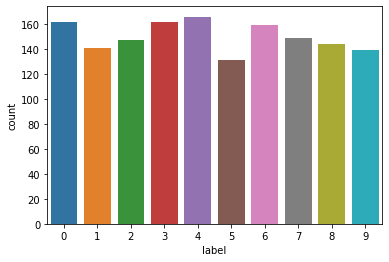

In [15]:
sns.countplot(y_train)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


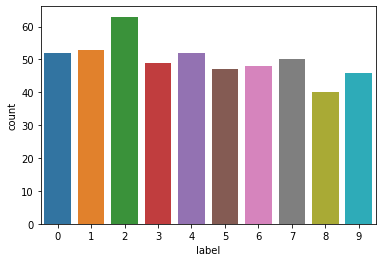

In [16]:
sns.countplot(y_test)
plt.show()

- 어떻게 생긴 데이터셋인지 확인해보기

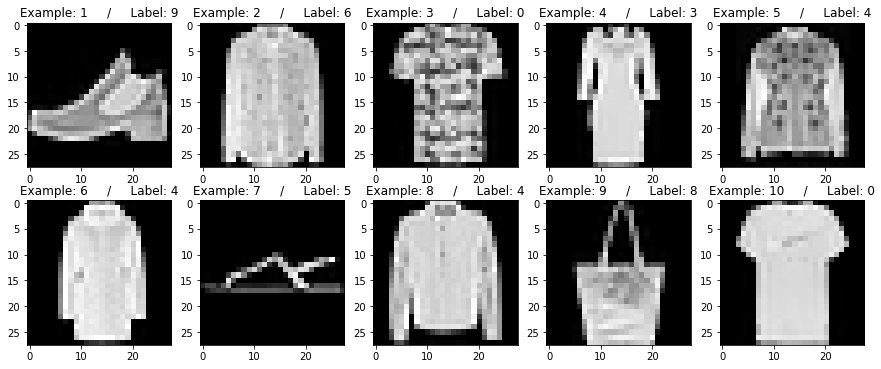

In [12]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 784)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA.shape

(1500, 784)

[0.28573291 0.17766021 0.06190009 0.05074614 0.04049808 0.03682071
 0.02214948 0.02020884 0.01362898 0.01284143]


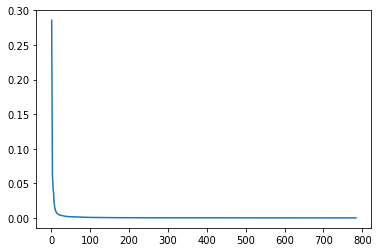

In [28]:
print(pca.explained_variance_ratio_[:10])
plt.plot(range(1, 785), pca.explained_variance_ratio_)
plt.show()

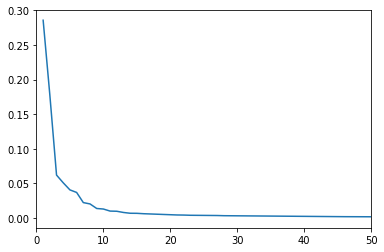

In [29]:
plt.plot(range(1, 785), pca.explained_variance_ratio_)
plt.xlim(0, 50)
plt.show()

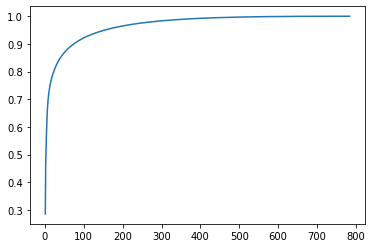

In [30]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)
plt.plot(range(1,785), cumulative)
plt.show()

In [31]:
cumulative = np.array(cumulative)
np.where(cumulative > 0.85)[0][0]

39

In [32]:
pca = PCA(n_components = 35)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [38]:
#LogisticRegression

start = time.time()
logistic_ori = LogisticRegression(max_iter = 1000)
logistic_ori.fit(X_train, y_train)
print('train_accuracy:', accuracy_score(y_train, logistic_ori.predict(X_train)))
print('test_accuracy:', accuracy_score(y_test, logistic_ori.predict(X_test)))
print(f'{time.time()-start :.4f}sec')

train_accuracy: 1.0
test_accuracy: 0.774
23.5118sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
start = time.time()
logistic_pca = LogisticRegression(max_iter = 1000)
logistic_pca.fit(X_train_PCA, y_train)
print('train_accuracy:', accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test_accuracy:', accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start: .4f}sec')

train_accuracy: 0.8793333333333333
test_accuracy: 0.798
 3.4425sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
#RandomForest
start = time.time()
rf_ori = RandomForestClassifier()
rf_ori.fit(X_train, y_train)
print('train_accuracy:', accuracy_score(y_train, rf_ori.predict(X_train)))
print('test_accuracy:', accuracy_score(y_test, rf_ori.predict(X_test)))
print(f'{time.time()-start: .4f}sec')

train_accuracy: 1.0
test_accuracy: 0.842
 2.4124sec


In [37]:
start = time.time()

rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train_accuracy:', accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test_accuracy:', accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start: .4f}sec')

train_accuracy: 1.0
test_accuracy: 0.808
 1.1189sec


### Logistic Regression의 경우 test accuracy에서 소폭 정확도 향상, 시간 면에서 약 8배의 시간 향상이 있었음

### RandomForest의 경우 test accuracy에서 소폭 정확도 하락이 있었지만 약 2배의 시간 향상이 있었음

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

 0.2817sec


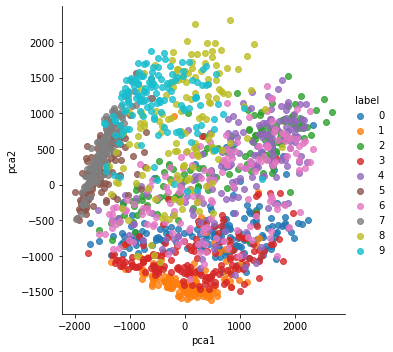

In [40]:
#pca

start = time.time()
pca = PCA(n_components= 2)
X_train_PCA = pca.fit_transform(X_train)
print(f'{time.time()-start: .4f}sec')
X_train_pca = pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca = pd.concat((X_train_pca, y_train), axis = 1)
X_train_pca.columns = ['pca1','pca2','label']

sns.lmplot(x = 'pca1', y = 'pca2', data = X_train_pca, hue = 'label', fit_reg = False)
plt.show()

 112.2665sec


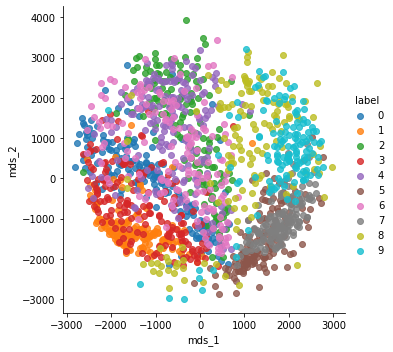

In [41]:
#MDS

from sklearn.manifold import MDS
start = time.time()
mds = MDS(n_components = 2, random_state = 42)
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start : .4f}sec')
X_train_mds = pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds = pd.concat((X_train_mds, y_train), axis = 1)
X_train_mds.columns = ['mds_1','mds_2','label']
X_train_mds

sns.lmplot(x = 'mds_1', y = 'mds_2', data = X_train_mds, hue = 'label', fit_reg = False)
plt.show()

 1.1411sec


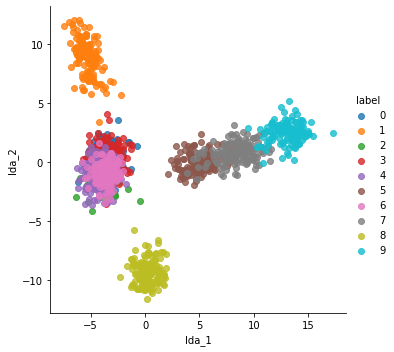

In [42]:
#LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start = time.time()
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_train, y_train)
print(f'{time.time()-start: .4f}sec')
X_train_lda = pd.DataFrame(X_train_lda).loc[:, 0:1]
X_train_lda = pd.concat((X_train_lda, y_train), axis = 1)
X_train_lda.columns = ['lda_1','lda_2','label']
X_train_lda

sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

 1.6086sec


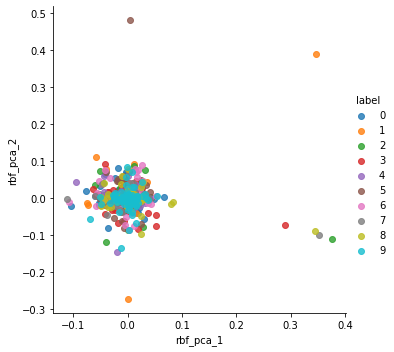

In [43]:
#KernelPCA_rbf

from sklearn.decomposition import KernelPCA
start = time.time()
rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.0433, fit_inverse_transform = True)
X_train_rbf_pca = rbf_pca.fit_transform(X_train)
print(f'{time.time()-start: .4f}sec')
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

1.6639sec


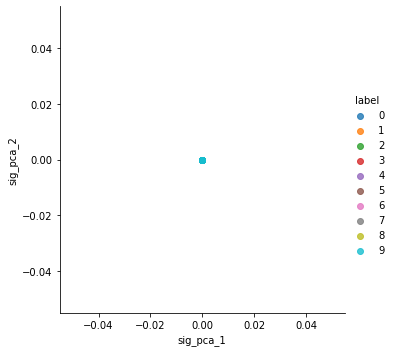

In [44]:
#KernelPCA_sigmoid
start = time.time()
sig_pca = KernelPCA(n_components = 2, kernel = 'sigmoid', gamma = 0.001, coef0 = 1, fit_inverse_transform = True)
X_train_sig_pca = sig_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

 1.2263sec


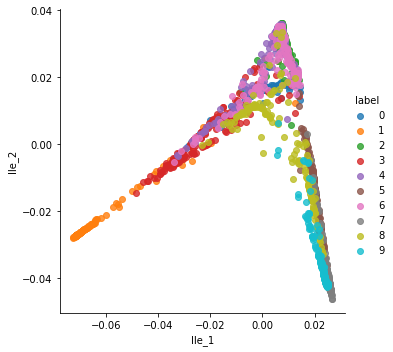

In [48]:
#LLE

from sklearn.manifold import LocallyLinearEmbedding
start = time.time()
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10, random_state = 42)
X_train_lle = lle.fit_transform(X_train)
print(f'{time.time()-start: .4f}sec')
X_train_lle = pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle = pd.concat((X_train_lle, y_train), axis = 1)
X_train_lle.columns = ['lle_1','lle_2', 'label']
X_train_lle

sns.lmplot(x = 'lle_1', y = 'lle_2', data = X_train_lle, hue = 'label', fit_reg = False)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


 14.6343sec


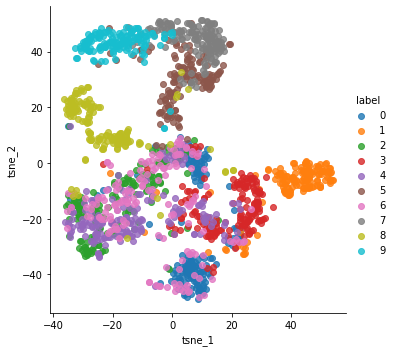

In [49]:
#tsne

from sklearn.manifold import TSNE
start = time.time()
tsne = TSNE(n_components = 2, random_state = 42)
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start: .4f}sec')
X_train_tsne = pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns = ['tsne_1','tsne_2', 'label']
X_train_tsne

sns.lmplot(x = 'tsne_1', y = 'tsne_2', data = X_train_tsne, hue = 'label', fit_reg = False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

- (A) LDA와 t-SNE 방식이 그나마 데이터셋을 잘 표현하는 것으로 보임

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

In [ ]:
- MDS : 데이터의 거리를 보존해 저차원에 맵핑하기 때문에 범주가 많은 상태에서 잘 표현하지 못할 것 같다
- PCA : 분산을 크게 하는 축을 중심으로 특징 추출을 하기 때문에 많은 범주가 있는 상태에서 잘 표현하지 못할 것 같다
- LDA : 여러 범주를 기준으로 축을 설정해 정확하지 않을 것같다.

수고하셨습니다~